In [1]:
import numpy as np
import os
import sys
import copy

import torch
torch.set_num_threads(os.cpu_count())
from torch import nn

import json

import matplotlib as mpl
import matplotlib.pyplot as plt

from pipnet import data
from pipnet import model
from pipnet import utils

device = "cuda" if torch.cuda.is_available() else "cpu"

np.random.seed(1)

In [2]:
mod = "PIPNet_2022_11_15_3_layers"

in_dir = f"../../data/2D/{mod}/"
fig_dir = f"../../figures/2D/{mod}/"

n_eval = 16
overwrite = False

eval_history = True
epochs_history = [
    0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99, 
    109, 119, 129, 139, 149, 159, 169, 179, 189, 199,
    209, 219, 229, 239, 249, 259, 269, 279, 289, 299,

]


eval_evolution = True
epochs_evolution = [
    0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99, 
    109, 119, 129, 139, 149, 159, 169, 179, 189, 199,
    209, 219, 229, 239, 249, 259, 269, 279, 289, 299,

]

iso_pars = dict(
    td = 128,
    Fs = 3_200,
    nmin = 1,
    nmax = 5,
    freq_range = [500., 2700.],
    gmin = 1,
    gmax = 1,
    spread = 5.,
    lw_range = [[5e1, 2e2], [1e2, 5e2], [1e2, 1e3]],
    lw_probs = [0.4, 0.3, 0.3],
    int_range = [0.1, 1.], # Intensity
    norm_height = True,
    phase = 0.,
    debug = False,
)

mas_pars = dict(
    nw = 12,
    mas_w_range = [50_000., 100_000.],
    random_mas = True,
    mas_phase_p = 0.5,
    mas_phase_scale = 0.05,
    
    # First-order MAS-dependent parameters
    mas1_lw_range = [[1e7, 5e7], [5e7, 1e8]],
    mas1_lw_probs = [0.6, 0.4],
    mas1_m_range = [[0., 0.], [0., 1e4], [1e4, 5e4]],
    mas1_m_probs = [0.2, 0.2, 0.6],
    mas1_s_range = [[-1e7, 1e7]],
    mas1_s_probs = [1.],

    # Second-order MAS-dependent parameters
    mas2_prob = 1.,
    mas2_lw_range = [[0., 0.], [1e11, 5e11]],
    mas2_lw_probs = [0.5, 0.5],
    mas2_m_range = [[0., 0.], [1e8, 5e8]],
    mas2_m_probs = [0.6, 0.4],
    mas2_s_range = [[0., 0.], [-2e10, 2e10]],
    mas2_s_probs = [0.6, 0.4],
    
    # Other MAS-dependent parameters
    non_mas_p = 0.5,
    non_mas_m_trends = ["constant", "increase", "decrease"],
    non_mas_m_probs = [0.34, 0.33, 0.33],
    non_mas_m_range = [0., 1.],
    
    int_decrease_p = 0.1,
    int_decrease_scale =[0.3, 0.7],
    debug = False,
)

data_pars = dict(
    iso_pars = iso_pars,
    mas_pars = mas_pars,
    
    positive_iso = True,
    encode_imag = False, # Encode the imaginary part of the MAS spectra
    encode_wr = True, # Encode the MAS rate of the spectra

    # noise parameters
    noise = 0., # Noise level
    mas_l_noise = 0.05,
    mas_s_noise = 25.,
    
    smooth_end_len = 10, # Smooth ends of spectra
    iso_spec_norm = 1.5, # Normalization factor for peaks
    mas_spec_norm = 0.5, # Normalization factor for MAS spectra
    wr_norm_factor = 100_000.,
    wr_inv = False, # Encode inverse of MAS rate instead of MAS rate
    gen_mas_shifts = True,
)

loss_pars1 = dict(
    trg_fuzz = 0.,
    trg_fuzz_len = 0,
    ndim = 1,
    exp = 1.0,
    offset = 1.0,
    factor = 0.0,
    int_w = 1.0,
    int_exp = 1.0,
    return_components = True,
    device = device,
)

loss_pars2 = dict(
    trg_fuzz = 0.,
    trg_fuzz_len = 0,
    ndim = 1,
    exp = 2.0,
    offset = 1.0,
    factor = 0.0,
    int_w = 1.0,
    int_exp = 2.0,
    return_components = True,
    device = device,
)

dataset = data.Dataset2D(params_x=data_pars, params_y=data_pars)

In [3]:
if not os.path.exists(in_dir):
    raise ValueError(f"Unknown model: {mod}")
    
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

In [4]:
with open(in_dir + "model_pars.json", "r") as F:
    model_pars = json.load(F)
model_pars["noise"] = 0.

In [5]:
# Load loss and learning rate
all_lrs = np.load(in_dir + "all_lrs.npy")
all_losses = np.load(in_dir + "all_losses.npy")
all_val_losses = np.load(in_dir + "all_val_losses.npy")

try:
    all_loss_components = np.load(in_dir + "all_loss_components.npy")
    all_val_loss_components = np.load(in_dir + "all_val_loss_components.npy")
    mean_loss_components = np.mean(all_loss_components, axis=1)
    mean_val_loss_components = np.mean(all_val_loss_components, axis=1)
except:
    all_loss_components = None
    all_val_loss_components = None
    mean_loss_components = None
    mean_val_loss_components = None

mean_losses = np.mean(all_losses, axis=1)
mean_val_losses = np.mean(all_val_losses, axis=1)

n_epochs = all_losses.shape[0]
best_epoch = np.argmin(mean_val_losses)
print(n_epochs, best_epoch)

139 78


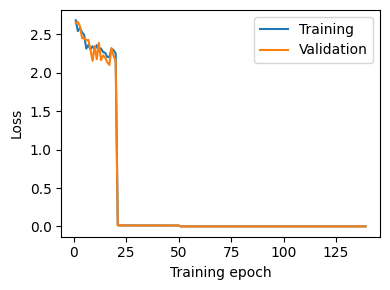

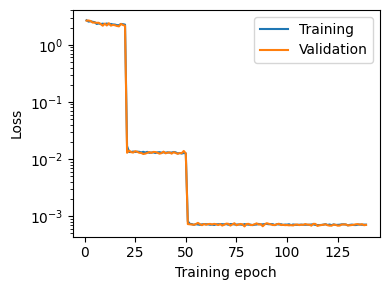

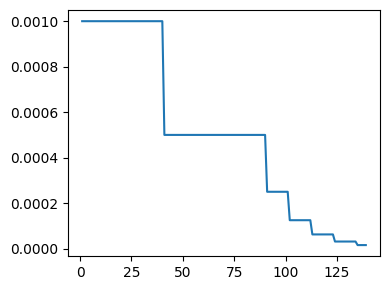

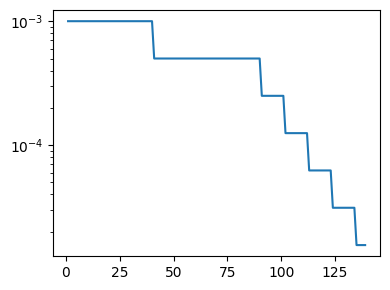

In [6]:
# Plot loss
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.plot(range(1, n_epochs+1), mean_losses)
ax.plot(range(1, n_epochs+1), mean_val_losses)

ax.set_xlabel("Training epoch")
ax.set_ylabel("Loss")

ax.legend(["Training", "Validation"])

fig.tight_layout()

plt.savefig(fig_dir + "loss.pdf")

plt.show()
plt.close()

# Plot loss, log
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.semilogy(range(1, n_epochs+1), mean_losses)
ax.semilogy(range(1, n_epochs+1), mean_val_losses)

ax.set_xlabel("Training epoch")
ax.set_ylabel("Loss")

ax.legend(["Training", "Validation"])

fig.tight_layout()

plt.savefig(fig_dir + "loss_log.pdf")

plt.show()
plt.close()

# Plot learning rate
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.plot(range(1, n_epochs+1), np.mean(all_lrs, axis=1))

fig.tight_layout()

plt.savefig(fig_dir + "lrs.pdf")

plt.show()
plt.close()

# Plot learning rate, log
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.semilogy(range(1, n_epochs+1), np.mean(all_lrs, axis=1))

fig.tight_layout()

plt.savefig(fig_dir + "lrs_log.pdf")

plt.show()
plt.close()

In [7]:
if np.any(mean_loss_components != 0.):

    # Plot loss components
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(1,1,1)

    hs = []

    ax.plot(range(1, n_epochs+1), mean_losses, f"k:")
    ax.plot(range(1, n_epochs+1), mean_val_losses, f"k")
    hs.append(mpl.lines.Line2D([0], [0], color=f"k"))

    for i in range(mean_loss_components.shape[-1]):
        ax.plot(range(1, n_epochs+1), mean_loss_components[:, i], f"C{i}:")
        ax.plot(range(1, n_epochs+1), mean_val_loss_components[:, i], f"C{i}")
        hs.append(mpl.lines.Line2D([0], [0], color=f"C{i}"))

    hs.append(mpl.lines.Line2D([0], [0], color="k", linestyle=":"))
    hs.append(mpl.lines.Line2D([0], [0], color="k"))

    ax.set_xlabel("Training epoch")
    ax.set_ylabel("Loss")
    
    labels = ["Total"]
    labels.extend(loss_components)
    labels.append("Training")
    labels.append("Validation")

    ax.legend(hs, labels)

    fig.tight_layout()

    plt.savefig(fig_dir + "loss_components.pdf")

    plt.show()
    plt.close()

    # Plot loss components, log
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(1,1,1)

    hs = []

    ax.plot(range(1, n_epochs+1), mean_losses, f"k:")
    ax.plot(range(1, n_epochs+1), mean_val_losses, f"k")
    hs.append(mpl.lines.Line2D([0], [0], color=f"k"))

    for i in range(mean_loss_components.shape[-1]):
        ax.plot(range(1, n_epochs+1), mean_loss_components[:, i], f"C{i}:")
        ax.plot(range(1, n_epochs+1), mean_val_loss_components[:, i], f"C{i}")
        hs.append(mpl.lines.Line2D([0], [0], color=f"C{i}"))

    hs.append(mpl.lines.Line2D([0], [0], color="k", linestyle=":"))
    hs.append(mpl.lines.Line2D([0], [0], color="k"))

    ax.set_xlabel("Training epoch")
    ax.set_ylabel("Loss")

    ax.set_yscale("log")

    ax.legend(hs, labels)

    fig.tight_layout()

    plt.savefig(fig_dir + "loss_components_log.pdf")

    plt.show()
    plt.close()

In [8]:
if np.any(mean_loss_components != 0.):

    for i in range(mean_loss_components.shape[-1]):
        # Plot loss components
        fig = plt.figure(figsize=(4,3))
        ax = fig.add_subplot(1,1,1)
        
        ax.plot(range(1, n_chk+1), mean_loss_components[:, i])
        ax.plot(range(1, n_chk+1), mean_val_loss_components[:, i])
        hs.append(mpl.lines.Line2D([0], [0], color=f"C{i}"))

        ax.set_xlabel("Training epoch")
        ax.set_ylabel("Loss")

        ax.legend(["Training", "Validation"])

        fig.tight_layout()

        plt.savefig(fig_dir + f"loss_component_{i}.pdf")

        plt.show()
        plt.close()
        
    for i in range(mean_loss_components.shape[-1]):
        # Plot loss components
        fig = plt.figure(figsize=(4,3))
        ax = fig.add_subplot(1,1,1)
        
        ax.semilogy(range(1, n_chk+1), mean_loss_components[:, i])
        ax.semilogy(range(1, n_chk+1), mean_val_loss_components[:, i])
        hs.append(mpl.lines.Line2D([0], [0], color=f"C{i}"))

        ax.set_xlabel("Training epoch")
        ax.set_ylabel("Loss")

        ax.legend(["Training", "Validation"])

        fig.tight_layout()

        plt.savefig(fig_dir + f"loss_component_{i}_log.pdf")

        plt.show()
        plt.close()

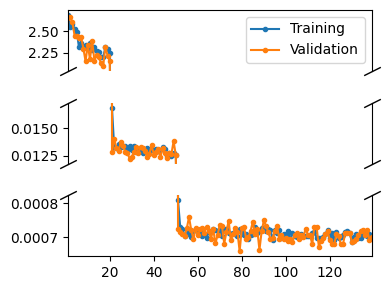

In [9]:
d = 0.5
max_diff = 0.5

mean_losses_dif = np.abs(mean_losses[1:] - mean_losses[:-1])
rel_diffs = mean_losses_dif / mean_losses[:-1]
jumps = np.where(rel_diffs > max_diff)[0]+1

if len(jumps) > 0:

    fig = plt.figure(figsize=(4,3))

    axs = []
    for i in range(len(jumps) + 1):
        axs.append(fig.add_subplot(len(jumps)+1, 1,i+1))

        # Plot broken axes markers
        if i > 0:
            axs[i].plot([0, 1], [1, 1], transform=axs[i].transAxes, marker=[(-1, -d), (1, d)],
                        markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False)

            axs[i].spines["top"].set_visible(False)

        if i < len(jumps):
            axs[i].plot([0, 1], [0, 0], transform=axs[i].transAxes, marker=[(-1, -d), (1, d)],
                        markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False)

            axs[i].spines["bottom"].set_visible(False)
            axs[i].set_xticks([])

        h1 = axs[i].plot(range(1, n_epochs+1), mean_losses, ".-")
        h2 = axs[i].plot(range(1, n_epochs+1), mean_val_losses, ".-")
        axs[i].set_xlim(1, n_epochs)

        if i == 0:
            M = np.max(mean_losses[:jumps[i]])
            M = max(M, np.max(mean_val_losses[:jumps[i]]))
            m = np.min(mean_losses[:jumps[i]])
            m = min(M, np.min(mean_val_losses[:jumps[i]]))

        elif i == len(jumps):
            M = np.max(mean_losses[jumps[i-1]:])
            M = max(M, np.max(mean_val_losses[jumps[i-1]:]))
            m = np.min(mean_losses[jumps[i-1]:])
            m = min(m, np.min(mean_val_losses[jumps[i-1]:]))

        else:
            M = np.max(mean_losses[jumps[i-1]:jumps[i]])
            M = max(M, np.max(mean_val_losses[jumps[i-1]:jumps[i]]))
            m = np.min(mean_losses[jumps[i-1]:jumps[i]])
            m = min(m, np.min(mean_val_losses[jumps[i-1]:jumps[i]]))

        r = M - m

        axs[i].set_ylim(m - 0.1 * r, M + 0.1 * r)

    axs[0].legend([h1[0], h2[0]], ["Training", "Validation"])

    fig.tight_layout()

    plt.savefig(fig_dir + "loss_split.pdf")

    plt.show()
    plt.close()

In [10]:
d = 0.1
max_diff = 0.5

if np.any(mean_loss_components != 0.):

    for k in range(mean_loss_components.shape[-1]):
        
        pp = f"Loss component {k}:\n"
        
        pp += "Training loss minimum: {:.3e}, mean over 10 last epochs: {:.3e}\n".format(np.min(mean_loss_components[:, k]), np.mean(mean_loss_components[-10:, k]))
        pp += "Validation loss minimum: {:.3e}, mean over 10 last epochs: {:.3e}\n".format(np.min(mean_val_loss_components[:, k]), np.mean(mean_val_loss_components[-10:, k]))
        print(pp)
        
        with open(f"{fig_dir}loss_component_{k}_summary.txt", "w") as F:
            F.write(pp)

        diffs = np.abs(mean_loss_components[1:, k] - mean_loss_components[:-1, k])
        rel_diffs = diffs / mean_loss_components[:-1, k]
        jumps = np.where(rel_diffs > max_diff)[0]+1
        
#        jumps = [jumps[-1]]
        jumps = [50]

        if len(jumps) > 0:

            fig = plt.figure(figsize=(4,3))

            axs = []
            for i in range(len(jumps) + 1):
                axs.append(fig.add_subplot(len(jumps)+1, 1,i+1))

                # Plot broken axes markers
                if i > 0:
                    axs[i].plot([0, 1], [1, 1], transform=axs[i].transAxes, marker=[(-1, -d), (1, d)],
                                markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False)

                    axs[i].spines["top"].set_visible(False)

                if i < len(jumps):
                    axs[i].plot([0, 1], [0, 0], transform=axs[i].transAxes, marker=[(-1, -d), (1, d)],
                                markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False)

                    axs[i].spines["bottom"].set_visible(False)
                    axs[i].set_xticks([])

                h1 = axs[i].plot(range(1, n_epochs+1), mean_loss_components[:, k], ".-")
                h2 = axs[i].plot(range(1, n_epochs+1), mean_val_loss_components[:, k], ".-")
                axs[i].set_xlim(1, n_epochs)

                if i == 0:
                    M = np.max(mean_loss_components[:jumps[i], k])
                    M = max(M, np.max(mean_val_loss_components[:jumps[i], k]))
                    m = np.min(mean_loss_components[:jumps[i], k])
                    m = min(M, np.min(mean_val_loss_components[:jumps[i], k]))

                elif i == len(jumps):
                    M = np.max(mean_loss_components[jumps[i-1]:, k])
                    M = max(M, np.max(mean_val_loss_components[jumps[i-1]:, k]))
                    m = np.min(mean_loss_components[jumps[i-1]:, k])
                    m = min(m, np.min(mean_val_loss_components[jumps[i-1]:, k]))

                else:
                    M = np.max(mean_loss_components[jumps[i-1]:jumps[i], k])
                    M = max(M, np.max(mean_val_loss_components[jumps[i-1]:jumps[i], k]))
                    m = np.min(mean_loss_components[jumps[i-1]:jumps[i], k])
                    m = min(m, np.min(mean_val_loss_components[jumps[i-1]:jumps[i], k]))

                r = M - m

                axs[i].set_ylim(m - 0.1 * r, M + 0.1 * r)

            axs[0].legend([h1[0], h2[0]], ["Training", "Validation"])

            fig.tight_layout()

            plt.savefig(fig_dir + f"loss_component_{k}_split.pdf")

            plt.show()
            plt.close()

# Evaluate the model history

In [11]:
if eval_history:

    fdir = fig_dir + "eval_history/"

    if not os.path.exists(fdir):
        os.mkdir(fdir)

    for i in range(n_epochs):
        
        if (epochs_history == "all" or i in epochs_history) and os.path.exists(in_dir + f"epoch_{i+1}_in.npy"):

            print(f"Epoch {i+1}...")

            d = fdir + f"epoch_{i+1}/"
            if not os.path.exists(d):
                os.mkdir(d)

            if overwrite or not os.path.exists(d + "sample_1.pdf"):

                X = np.load(in_dir + f"epoch_{i+1}_in.npy")
                
                # Temporary fix to handle bugged rotation
                X[:, :, 1] = np.max(X[:, :, 1], axis=(2, 3))[:, :, np.newaxis, np.newaxis]
                
                Z_trg = np.load(in_dir + f"epoch_{i+1}_trg.npy")
                Z_pred = np.load(in_dir + f"epoch_{i+1}_pred.npy")
                
                for isample in range(X.shape[0]):
                    utils.plot_2d_iso_prediction(
                        X[isample],
                        Z_pred[isample],
                        y_trg=Z_trg[isample, 0],
                        xvals=dataset.xgen.f,
                        yvals=dataset.ygen.f,
                        wr_factor=dataset.xgen.norm_wr,
                        all_steps=isample==0,
                        show=False,
                        level_neg=True,
                        save=d + f"sample_{isample+1}.pdf"
                    )

print("All done!")

Epoch 10...
Epoch 50...
Epoch 100...
All done!


# Load model and generate dataset

In [12]:
if eval_evolution:

    net = model.ConvLSTMEnsemble(**model_pars)
    net.eval()
    
    X, y = dataset.generate_batch(size=n_eval)
    
    fdir = fig_dir + "eval_evolution/"

    if not os.path.exists(fdir):
        os.mkdir(fdir)

    for i in range(n_epochs):
        
        if (epochs_evolution == "all" or i in epochs_evolution) and os.path.exists(in_dir + f"epoch_{i+1}_network"):

            print(f"Epoch {i+1}...")
            
            net.load_state_dict(torch.load(in_dir + f"epoch_{i+1}_network", map_location=torch.device(device)))

            d = fdir + f"epoch_{i+1}/"
            if not os.path.exists(d):
                os.mkdir(d)

            if overwrite or not os.path.exists(d + "sample_1.pdf"):
                
                with torch.no_grad():
                    Z_pred, _, _ = net(X)
                Z_pred = Z_pred.numpy()
                
                Z_trg = y.repeat(1, Z_pred.shape[1], 1, 1).numpy()
                    
                for isample in range(X.shape[0]):
                    utils.plot_2d_iso_prediction(
                        X[isample].numpy(),
                        Z_pred[isample],
                        y_trg=Z_trg[isample, 0],
                        xvals=dataset.xgen.f,
                        yvals=dataset.ygen.f,
                        wr_factor=dataset.xgen.norm_wr,
                        all_steps=isample==0,
                        show=False,
                        level_neg=True,
                        save=d + f"sample_{isample+1}.pdf"
                    )

print("All done!")

Epoch 10...
Epoch 50...
Epoch 100...
All done!
